# Test whether 1h data is needed

In [5]:
%load_ext autoreload
%autoreload 2

In [7]:
from src.score import *
# from src.train_nn import *
import matplotlib.pyplot as plt

In [8]:
datadir = '/data/stephan/WeatherBench/5.625deg/'
var_dict = {'geopotential': ('z', [500]), 'temperature': ('t', [850])}
output_vars = None
filters = [64, 64, 64, 64, 2]
kernels = [5, 5, 5, 5, 5]
lead_time = 72
batch_size = 128
activation = 'elu'

## New data generator

In [4]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [5]:
ds_train = ds.sel(time=slice('1979', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [6]:
ds_train

<xarray.Dataset>
Dimensions:  (lat: 32, level: 11, lon: 64, time: 324336)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * level    (level) int32 1 10 100 200 300 400 500 600 700 850 1000
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 1979-01-01 ... 2015-12-31T23:00:00
Data variables:
    z        (time, level, lat, lon) float32 dask.array<chunksize=(8760, 11, 32, 64), meta=np.ndarray>
    t        (time, level, lat, lon) float32 dask.array<chunksize=(8760, 11, 32, 64), meta=np.ndarray>

In [18]:
dt = ds_train.time.diff('time')[0].values / np.timedelta64(1, 'h')

In [21]:
dt.is_integer()

True

In [22]:
 72 /6

12.0

In [30]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True,
                 mean=None, std=None, output_vars=None, data_subsample=1, norm_subsample=1):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        print('DG start', datetime.datetime.now().time())
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        level_names = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for long_var, params in var_dict.items():
            if long_var == 'constants':
                for var in params:
                    data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
                    level_names.append(var)
            else:
                var, levels = params
                try:
                    data.append(ds[var].sel(level=levels))
                    level_names += [f'{var}_{level}' for level in levels]
                except ValueError:
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
                    level_names.append(var)

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.data['level_names'] = xr.DataArray(
            level_names, dims=['level'], coords={'level': self.data.level})
        if output_vars is None:
            self.output_idxs = range(len(self.data.level))
        else:
            self.output_idxs = [i for i, l in enumerate(self.data.level_names.values)
                                if any([bool(re.match(o, l)) for o in output_vars])]
        
        # Subsample
        self.data = self.data.isel(time=slice(0, None, data_subsample))
        self.dt = self.data.time.diff('time')[0].values / np.timedelta64(1, 'h')
        assert (self.lead_time / self.dt).is_integer(), "lead_time and dt not compatible."
        self.nt = int(self.lead_time / self.dt)
        
        # Normalize
        print('DG normalize', datetime.datetime.now().time())
        self.mean = self.data.isel(time=slice(0, None, norm_subsample)).mean(
            ('time', 'lat', 'lon')).compute() if mean is None else mean
        #         self.std = self.data.std('time').mean(('lat', 'lon')).compute() if std is None else std
        self.std = self.data.isel(time=slice(0, None, norm_subsample)).std(
            ('time', 'lat', 'lon')).compute() if std is None else std
        self.data = (self.data - self.mean) / self.std

        self.n_samples = self.data.isel(time=slice(0, -self.nt)).shape[0]
        self.init_time = self.data.isel(time=slice(0, -self.nt)).time
        self.valid_time = self.data.isel(time=slice(self.nt, None)).time

        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        print('DG load', datetime.datetime.now().time())
        if load: print('Loading data into RAM'); self.data.load()
        print('DG done', datetime.datetime.now().time())

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.data.isel(time=idxs + self.nt, level=self.output_idxs).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)

In [31]:
dg_train = DataGenerator(ds_train, var_dict, lead_time, batch_size=batch_size, 
                         output_vars=output_vars, data_subsample=6, norm_subsample=20000)
dg_valid = DataGenerator(ds_valid, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean,
                         std=dg_train.std, shuffle=False, output_vars=output_vars)
dg_test =  DataGenerator(ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean,
                         std=dg_train.std, shuffle=False, output_vars=output_vars)
print(f'Mean = {dg_train.mean}; Std = {dg_train.std}')

DG start 09:58:17.796737
DG normalize 09:58:17.817060
DG load 09:58:20.850457
Loading data into RAM
DG done 09:58:39.789801
DG start 09:58:39.790622
DG normalize 09:58:39.799591
DG load 09:58:39.806914
Loading data into RAM
DG done 09:58:40.434889
DG start 09:58:40.435710
DG normalize 09:58:40.445164
DG load 09:58:40.451914
Loading data into RAM
DG done 09:58:41.553692
Mean = <xarray.DataArray 'z' (level: 2)>
array([54098.188  ,   274.42715], dtype=float32)
Coordinates:
  * level        (level) int64 500 850
    level_names  (level) <U5 'z_500' 't_850'; Std = <xarray.DataArray 'z' (level: 2)>
array([3336.1562  ,   15.807501], dtype=float32)
Coordinates:
  * level        (level) int64 500 850
    level_names  (level) <U5 'z_500' 't_850'


In [33]:
X, y = dg_train[0]

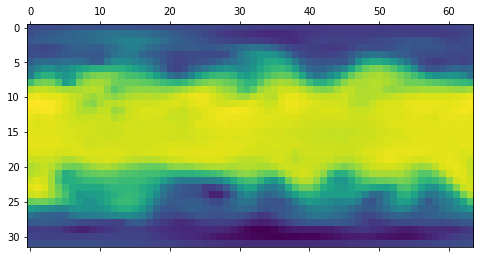

In [36]:
plt.matshow(X[0, :, :, 0])

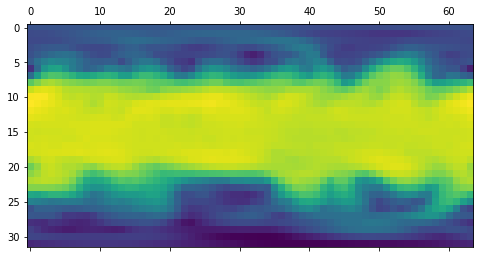

In [37]:
plt.matshow(y[0, :, :, 0])

In [38]:
model = build_cnn(filters, kernels, input_shape=(32, 64, len(dg_train.data.level)), activation=activation)
model.compile(keras.optimizers.Adam(), 'mse')

[autoreload of h5py failed: Traceback (most recent call last):
  File "/home/stephan/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/stephan/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/stephan/miniconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/stephan/miniconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/stephan/miniconda3/lib/python3.6/site-packages/h5py/__init__.py", line 55, in <module>
    from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z, h5

In [39]:
h = model.fit_generator(dg_train, epochs=1)

Epoch 1/1
423/423 [==============================] - 33s 79ms/step - loss: 9.8180


In [40]:
type(h)

tensorflow.python.keras.callbacks.History

In [41]:
h

In [43]:
h.epoch

[0]

## Compare training

In [9]:
from src.utils import *

In [37]:
!ls /home/stephan/data/myWeatherBench/predictions/saved_models/*hist*

/home/stephan/data/myWeatherBench/predictions/saved_models/01.1-default_no_es_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/02-6h_subsample_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/03-12h_subsample_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/04-36h_subsample_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/05-2.5e-4_no_decay_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/06-decay_10_5_history.pkl
/home/stephan/data/myWeatherBench/predictions/saved_models/test_history.pkl


In [38]:
h01 = read_pickle(
    '/home/stephan/data/myWeatherBench/predictions/saved_models/01.1-default_no_es_history.pkl')
h02 = read_pickle(
    '/home/stephan/data/myWeatherBench/predictions/saved_models/02-6h_subsample_history.pkl')
h03 = read_pickle(
    '/home/stephan/data/myWeatherBench/predictions/saved_models/03-12h_subsample_history.pkl')
h04 = read_pickle(
    '/home/stephan/data/myWeatherBench/predictions/saved_models/04-36h_subsample_history.pkl')

In [39]:
def plot_hist(h, ax=None, ylim=None):
    if ax is None: fig, ax = plt.subplots()
    ax.plot(h['loss'], label='train')
    ax.plot(h['val_loss'], label='valid')
    ax.legend()
    if ylim is not None: ax.set_ylim(ylim)

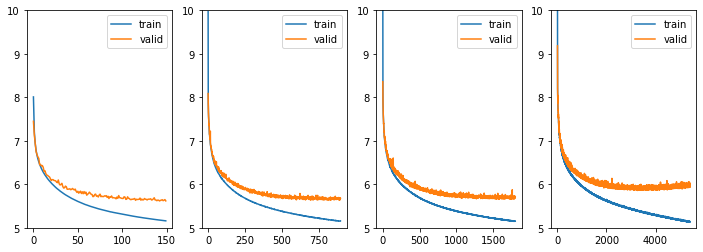

In [40]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
for h, ax in zip([h01, h02, h03, h04], axs):
    plot_hist(h, ax, (5, 10))
for ax in axs:
    pass
#     ax.set_yscale('log')

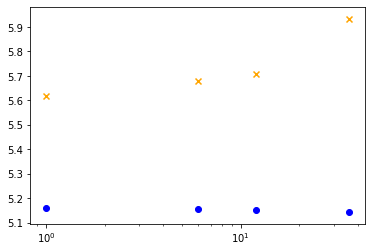

In [42]:
for h, ss in zip([h01, h02, h03, h04], [1, 6, 12, 36]):
    plt.scatter(ss, h['loss'][-1], c='b')
    plt.scatter(ss, h['val_loss'][-1], c='orange', marker='x')
plt.xscale('log')